In [1]:
### TSX and CSK displacement plots for periods A-E
"""
steps:
1.  Load dependencies
2.  Load Time series data
3.  Load external data (DEM, shapefiles)
4.  Plot displacement magnitude
5.  Plot displacement vector maps
6.  Plot range offset
7.  Plot azimuth offset

"""



'\nsteps:\n1.  Load dependencies\n2.  Load Time series data\n3.  Load external data (DEM, shapefiles)\n4.  Plot displacement magnitude\n5.  Plot displacement vector maps\n6.  Plot range offset\n7.  Plot azimuth offset\n\n'

In [2]:
## 1. Load dependencies

## first time series test
# append ../../ to make link to main repo work
import sys
sys.path.append('../../')

# import external packages
import numpy as np
import pandas as pd
import numba
from numba import vectorize
import glob # for file search
import copy
import os # operating system stuff
import re # regex


import geopandas as gpd
import rasterio as rio
import rasterio.mask
from rasterio.plot import plotting_extent
from shapely.geometry import Polygon
from shapely.geometry.point import Point
import pyproj
from pyproj import CRS
from inpoly import inpoly2 # for fast inpolygon checks
import utm

import matplotlib.pyplot as plt 
import matplotlib.dates as mdates
from matplotlib import cm as mpl_cm
from matplotlib import colors as mcolors 
import matplotlib.image as mplimg

from mpl_toolkits.axes_grid1 import make_axes_locatable # for colorbar scaling
from mpl_toolkits.axes_grid1 import ImageGrid
from matplotlib_scalebar.scalebar import ScaleBar
from matplotlib.gridspec import GridSpec
from matplotlib.ticker import FormatStrFormatter

import seaborn as sns
from matplotlib import rc_file_defaults
rc_file_defaults()
# sns.set(style=None, color_codes=True)

from shapely.geometry import Polygon
from shapely.geometry.point import Point
import datetime

import configparser

from cmcrameri import cm # for scientific colourmaps

###########################
# import main local package
import SPOTSAR_main as sm


In [3]:
## load TS data

# load SPOT time-series data
# CSK
CSK_TS_FILE = '/Users/tz20896/Documents/PhD/projects/Merapi2021/CSK/dsc1/CSK_SPOT_dsc_win13_ts_inv.csv'
CSK_TS = pd.read_csv(CSK_TS_FILE)
# TSX
TSX_TS_FILE = '/Users/tz20896/Documents/PhD/projects/Merapi2021/TSX/staring_134/TSX_ST134_win13_ts_inv.csv'
TSX_TS = pd.read_csv(TSX_TS_FILE)

# show TS data

print(CSK_TS)
print(TSX_TS)

CSK_TS_new = CSK_TS.iloc[:,2:]
print(CSK_TS_new)
# CSK_TS_new.to_csv(CSK_TS_FILE)

## load external data

### get EDM positions
pos_bad = np.array([110.410626, -7.526175])
reflectors = np.array(
    [[110.439757, -7.537567], [110.440165, -7.537451], [110.439260, -7.537533]]
)

### lava flows and crater
L1888_FILE = ("/Users/tz20896/Documents/PhD/projects/Merapi2021/merapi_maps/L1888_v2.shp")
L1948_FILE = ("/Users/tz20896/Documents/PhD/projects/Merapi2021/merapi_maps/L1948.shp")
L1956_FILE = ("/Users/tz20896/Documents/PhD/projects/Merapi2021/merapi_maps/L1956.shp")
L1992_FILE = ("/Users/tz20896/Documents/PhD/projects/Merapi2021/merapi_maps/L1992.shp")
L1997_FILE = ("/Users/tz20896/Documents/PhD/projects/Merapi2021/merapi_maps/L1997.shp")
L1998_FILE = ("/Users/tz20896/Documents/PhD/projects/Merapi2021/merapi_maps/L1998.shp")
L1986_FILE = ("/Users/tz20896/Documents/PhD/projects/Merapi2021/merapi_maps/L1986.shp")
L1984_FILE = ("/Users/tz20896/Documents/PhD/projects/Merapi2021/merapi_maps/L1984.shp")
L1931_FILE = ("/Users/tz20896/Documents/PhD/projects/Merapi2021/merapi_maps/L1931.shp")

OLD_CRATER_FILE = ("/Users/tz20896/Documents/PhD/projects/Merapi2021/merapi_maps/old_crater_rims.shp")
CRATER_FILE = "/Users/tz20896/Documents/PhD/projects/Merapi2021/merapi_maps/Merapi_crater.shp"

# Read the shapefile
L1948      = gpd.read_file(L1948_FILE)
L1888      = gpd.read_file(L1888_FILE)
L1956      = gpd.read_file(L1956_FILE)
L1992      = gpd.read_file(L1992_FILE)
L1997      = gpd.read_file(L1997_FILE)
L1998      = gpd.read_file(L1998_FILE)
L1986      = gpd.read_file(L1986_FILE)
L1984      = gpd.read_file(L1984_FILE)
L1931      = gpd.read_file(L1931_FILE)
OLD_CRATER = gpd.read_file(OLD_CRATER_FILE)
CRATER     = gpd.read_file(CRATER_FILE)

# Extract latitude and longitude into separate columns
coords_L1888   = np.array(list(L1888["geometry"][0].coords))
coords_L1956_1 = np.array(list(L1956["geometry"][0].coords))
coords_L1956_2 = np.array(list(L1956["geometry"][1].coords))
coords_L1948   = np.array(list(L1948["geometry"][0].coords))
coords_L1992   = np.array(list(L1992["geometry"][0].coords))
coords_L1997   = np.array(list(L1997["geometry"][0].coords))
coords_L1998   = np.array(list(L1998["geometry"][0].coords))
coords_L1986   = np.array(list(L1986["geometry"][0].coords))
coords_L1984   = np.array(list(L1984["geometry"][0].coords))
coords_L1931   = np.array(list(L1931["geometry"][0].coords))


coords_pas1_CRATER   = np.array(list(OLD_CRATER["geometry"][0].coords))
coords_pas2_CRATER   = np.array(list(OLD_CRATER["geometry"][1].coords))
coords_1822_CRATER   = np.array(list(OLD_CRATER["geometry"][2].coords))
coords_1872_CRATER   = np.array(list(OLD_CRATER["geometry"][3].coords))
coords_1904_1_CRATER = np.array(list(OLD_CRATER["geometry"][4].coords))
coords_1904_2_CRATER = np.array(list(OLD_CRATER["geometry"][5].coords))
coords_1932_CRATER   = np.array(list(OLD_CRATER["geometry"][6].coords))
coords_1961_1_CRATER = np.array(list(OLD_CRATER["geometry"][7].coords))
coords_1961_2_CRATER = np.array(list(OLD_CRATER["geometry"][8].coords))

coords_CRATER = np.array(list(CRATER["geometry"][0].coords))


## defien query points fro time series plot
Q_points = [(110.44595,-7.53895),
            (110.44364,-7.53659),
            (110.440165,-7.537451),
            (110.44000,-7.53831),
            (110.44322,-7.54022),
            (110.44280,-7.54211),
            (110.43365,-7.54146),
            (110.44493,-7.54096),
            (110.44611,-7.54102),
            (110.44894,-7.53674),
            ]


        Unnamed: 0   Longitude  Latitude  r_disp_  a_disp_  r_disp_20200910  \
0                0  110.483566 -7.519673      0.0      0.0        -0.081862   
1                1  110.483627 -7.519764      0.0      0.0        -0.110186   
2                2  110.483574 -7.519828      0.0      0.0        -0.116883   
3                3  110.483536 -7.519897      0.0      0.0        -0.141539   
4                4  110.483505 -7.519970      0.0      0.0        -0.152580   
...            ...         ...       ...      ...      ...              ...   
282265      310758  110.418274 -7.561081      0.0      0.0         0.012227   
282266      310761  110.427368 -7.509089      0.0      0.0        -0.021778   
282267      310764  110.418236 -7.561071      0.0      0.0         0.036422   
282268      310765  110.418282 -7.561155      0.0      0.0         0.046467   
282269      310775  110.418449 -7.560341      0.0      0.0         0.040927   

        a_disp_20200910  r_disp_20200919  a_disp_20

In [4]:
## get Disp results per period

## separate data per time period:

col_offset = 3
CSK_cols_r = list(CSK_TS)[col_offset+2::2]
TSX_cols_r = list(TSX_TS)[col_offset::2]

CSK_dates = [datetime.datetime.strptime(CSK_col_r[-8:],'%Y%m%d') for CSK_col_r in CSK_cols_r]
TSX_dates = [datetime.datetime.strptime(TSX_col_r[-8:],'%Y%m%d') for TSX_col_r in TSX_cols_r]
CSK_dates.append(datetime.datetime.strptime('20211101','%Y%m%d') ) # small error in to saved file
print(CSK_dates)
print(TSX_dates)

# CSK
# indexes of unique dates for date range
# CSK: 
# period 1: (calm before the storm) 0 -> 5 (2020-09-10 -> 2020-10-13) [2 cm/day]
# period 2: (the storm pt. 1) 5 -> 13 (2020-10-13 -> 2021-01-09) [20 cm/day]
# period 3: (the eye of the storm) 13 -> 37 (2021-01-09 -> 2021-07-11) [3 cm/day]
# period 4: (the storm pt. 2) 37 -> 42 (2021-07-11 -> 2021-08-13) [15 cm/day]
# period 5: (the calm after the storm) 42 -> 54 (2021-08-13 -> 2021-11-01) [2 cm/day]



CSK_delta_t_1 = CSK_dates[5] - CSK_dates[0]
CSK_delta_t_2 = CSK_dates[13] - CSK_dates[5]
CSK_delta_t_3 = CSK_dates[37] - CSK_dates[13]
CSK_delta_t_4 = CSK_dates[42] - CSK_dates[37]
CSK_delta_t_5 = CSK_dates[54] - CSK_dates[42]
CSK_delta_t_total = CSK_dates[-1] - CSK_dates[0]

print(CSK_delta_t_1)

CSK_R_disp_1 = (CSK_TS.iloc[:,col_offset+5 *2] - CSK_TS.iloc[:,col_offset+0*2])
CSK_R_disp_2 = (CSK_TS.iloc[:,col_offset+13*2] - CSK_TS.iloc[:,col_offset +5*2])
CSK_R_disp_3 = (CSK_TS.iloc[:,col_offset+37*2] - CSK_TS.iloc[:,col_offset+13*2])
CSK_R_disp_4 = (CSK_TS.iloc[:,col_offset+42*2] - CSK_TS.iloc[:,col_offset+37*2])
CSK_R_disp_5 = (CSK_TS.iloc[:,col_offset+54*2] - CSK_TS.iloc[:,col_offset+42*2])

CSK_A_disp_1 = (CSK_TS.iloc[:,col_offset +5*2 +1] - CSK_TS.iloc[:,col_offset+0*2 +1])
CSK_A_disp_2 = (CSK_TS.iloc[:,col_offset+13*2 +1] - CSK_TS.iloc[:,col_offset +5*2 +1])
CSK_A_disp_3 = (CSK_TS.iloc[:,col_offset+37*2 +1] - CSK_TS.iloc[:,col_offset+13*2 +1])
CSK_A_disp_4 = (CSK_TS.iloc[:,col_offset+42*2 +1] - CSK_TS.iloc[:,col_offset+37*2 +1])
CSK_A_disp_5 = (CSK_TS.iloc[:,col_offset+54*2 +1] - CSK_TS.iloc[:,col_offset+42*2 +1])

CSK_R_disp_rate_1 = (CSK_TS.iloc[:,col_offset+5 *2] - CSK_TS.iloc[:,col_offset+0*2])/CSK_delta_t_1.days
CSK_R_disp_rate_2 = (CSK_TS.iloc[:,col_offset+13*2] - CSK_TS.iloc[:,col_offset +5*2])/CSK_delta_t_2.days
CSK_R_disp_rate_3 = (CSK_TS.iloc[:,col_offset+37*2] - CSK_TS.iloc[:,col_offset+13*2])/CSK_delta_t_3.days
CSK_R_disp_rate_4 = (CSK_TS.iloc[:,col_offset+42*2] - CSK_TS.iloc[:,col_offset+37*2])/CSK_delta_t_4.days
CSK_R_disp_rate_5 = (CSK_TS.iloc[:,col_offset+54*2] - CSK_TS.iloc[:,col_offset+42*2])/CSK_delta_t_5.days

CSK_A_disp_rate_1 = (CSK_TS.iloc[:,col_offset +5*2 +1] - CSK_TS.iloc[:,col_offset+0*2 +1])/CSK_delta_t_1.days
CSK_A_disp_rate_2 = (CSK_TS.iloc[:,col_offset+13*2 +1] - CSK_TS.iloc[:,col_offset +5*2 +1])/CSK_delta_t_2.days
CSK_A_disp_rate_3 = (CSK_TS.iloc[:,col_offset+37*2 +1] - CSK_TS.iloc[:,col_offset+13*2 +1])/CSK_delta_t_3.days
CSK_A_disp_rate_4 = (CSK_TS.iloc[:,col_offset+42*2 +1] - CSK_TS.iloc[:,col_offset+37*2 +1])/CSK_delta_t_4.days
CSK_A_disp_rate_5 = (CSK_TS.iloc[:,col_offset+54*2 +1] - CSK_TS.iloc[:,col_offset+42*2 +1])/CSK_delta_t_5.days


CSK_R_disp_total = (CSK_TS.iloc[:,-2] - CSK_TS.iloc[:,col_offset])
CSK_A_disp_total = (CSK_TS.iloc[:,-1] - CSK_TS.iloc[:,col_offset+1])

CSK_R_disp_rate_total = (CSK_TS.iloc[:,-2] - CSK_TS.iloc[:,col_offset])/CSK_delta_t_total.days
CSK_A_disp_rate_total = (CSK_TS.iloc[:,-1] - CSK_TS.iloc[:,col_offset+1])/CSK_delta_t_total.days



# TSX:
# period 1: (calm before the storm) no data
# period 2: (the storm pt. 1) 0 -> 4 (2020-11-16 -> 2021-01-10) [20 cm/day]
# period 3: (the eye of the storm) 4 -> 12 (2021-01-10 -> 2021-06-13) [3 cm/day]
# period 4: (the storm pt. 2) 12 -> 13 (2021-06-13 -> 2021-10-01) [15 cm/day]
# period 5: (the calm after the storm) 13 -> 14 (2021-10-01 -> 2021-10-23) [2 cm/day]

TSX_delta_t_2 = TSX_dates[4] - TSX_dates[0]
TSX_delta_t_3 = TSX_dates[12] - TSX_dates[4]
TSX_delta_t_4 = TSX_dates[13] - TSX_dates[12]
TSX_delta_t_5 = TSX_dates[14] - TSX_dates[13]
TSX_delta_t_total = TSX_dates[14] - TSX_dates[0]

TSX_R_disp_2 = (TSX_TS.iloc[:,col_offset+4*2] - TSX_TS.iloc[:,col_offset +0*2]) 
TSX_R_disp_3 = (TSX_TS.iloc[:,col_offset+12*2] - TSX_TS.iloc[:,col_offset+4*2]) 
TSX_R_disp_4 = (TSX_TS.iloc[:,col_offset+13*2] - TSX_TS.iloc[:,col_offset+12*2])
TSX_R_disp_5 = (TSX_TS.iloc[:,col_offset+14*2] - TSX_TS.iloc[:,col_offset+13*2])

TSX_A_disp_2 = (TSX_TS.iloc[:,col_offset+4*2 +1] - TSX_TS.iloc[:,col_offset +0*2 +1])
TSX_A_disp_3 = (TSX_TS.iloc[:,col_offset+12*2 +1] - TSX_TS.iloc[:,col_offset+4*2 +1])
TSX_A_disp_4 = (TSX_TS.iloc[:,col_offset+13*2 +1] - TSX_TS.iloc[:,col_offset+12*2 +1])
TSX_A_disp_5 = (TSX_TS.iloc[:,col_offset+14*2 +1] - TSX_TS.iloc[:,col_offset+13*2 +1])

TSX_R_disp_rate_2 = (TSX_TS.iloc[:,col_offset+4*2] - TSX_TS.iloc[:,col_offset +0*2]) /TSX_delta_t_2.days
TSX_R_disp_rate_3 = (TSX_TS.iloc[:,col_offset+12*2] - TSX_TS.iloc[:,col_offset+4*2]) /TSX_delta_t_3.days
TSX_R_disp_rate_4 = (TSX_TS.iloc[:,col_offset+13*2] - TSX_TS.iloc[:,col_offset+12*2])/TSX_delta_t_4.days
TSX_R_disp_rate_5 = (TSX_TS.iloc[:,col_offset+14*2] - TSX_TS.iloc[:,col_offset+13*2])/TSX_delta_t_5.days

TSX_A_disp_rate_2 = (TSX_TS.iloc[:,col_offset+4*2 +1] - TSX_TS.iloc[:,col_offset +0*2 +1])/TSX_delta_t_2.days
TSX_A_disp_rate_3 = (TSX_TS.iloc[:,col_offset+12*2 +1] - TSX_TS.iloc[:,col_offset+4*2 +1])/TSX_delta_t_3.days
TSX_A_disp_rate_4 = (TSX_TS.iloc[:,col_offset+13*2 +1] - TSX_TS.iloc[:,col_offset+12*2 +1])/TSX_delta_t_4.days
TSX_A_disp_rate_5 = (TSX_TS.iloc[:,col_offset+14*2 +1] - TSX_TS.iloc[:,col_offset+13*2 +1])/TSX_delta_t_5.days


TSX_R_disp_total = (TSX_TS.iloc[:,-2] - TSX_TS.iloc[:,col_offset])
TSX_A_disp_total = (TSX_TS.iloc[:,-1] - TSX_TS.iloc[:,col_offset+1])

TSX_R_disp_rate_total = (TSX_TS.iloc[:,-2] - TSX_TS.iloc[:,col_offset])/TSX_delta_t_total.days
TSX_A_disp_rate_total = (TSX_TS.iloc[:,-1] - TSX_TS.iloc[:,col_offset+1])/TSX_delta_t_total.days


[datetime.datetime(2020, 9, 10, 0, 0), datetime.datetime(2020, 9, 19, 0, 0), datetime.datetime(2020, 9, 26, 0, 0), datetime.datetime(2020, 9, 27, 0, 0), datetime.datetime(2020, 10, 5, 0, 0), datetime.datetime(2020, 10, 12, 0, 0), datetime.datetime(2020, 10, 13, 0, 0), datetime.datetime(2020, 11, 13, 0, 0), datetime.datetime(2020, 11, 14, 0, 0), datetime.datetime(2020, 11, 22, 0, 0), datetime.datetime(2020, 12, 24, 0, 0), datetime.datetime(2020, 12, 31, 0, 0), datetime.datetime(2021, 1, 1, 0, 0), datetime.datetime(2021, 1, 9, 0, 0), datetime.datetime(2021, 1, 16, 0, 0), datetime.datetime(2021, 1, 17, 0, 0), datetime.datetime(2021, 1, 25, 0, 0), datetime.datetime(2021, 2, 1, 0, 0), datetime.datetime(2021, 2, 2, 0, 0), datetime.datetime(2021, 2, 17, 0, 0), datetime.datetime(2021, 2, 18, 0, 0), datetime.datetime(2021, 3, 2, 0, 0), datetime.datetime(2021, 3, 5, 0, 0), datetime.datetime(2021, 3, 6, 0, 0), datetime.datetime(2021, 3, 14, 0, 0), datetime.datetime(2021, 3, 21, 0, 0), datetime.da

In [5]:
import matplotlib.patches as mpatches
import matplotlib.transforms as mtransforms
def add_bottom_cax(ax, pad, height):
    axpos = ax.get_position()
    caxpos = mtransforms.Bbox.from_extents(
        axpos.x0,
        axpos.y0 - pad - height,
        axpos.x1,
        axpos.y0 - pad
    )
    cax = ax.figure.add_axes(caxpos)

    return cax


import json
from shapely.geometry import Point, LineString, mapping
from functools import partial
from shapely.ops import transform



# lon_lat = np.dstack((lon_vec,lat_vec))


def poly_circle_around_lon_lat(point,r):
    ##
    # function transforms query point (lon,lat)WGS84 into 
    # local azimuthal projection (rect-linear with minimum local distortion)
    # then applies a buffer of desired radius in meters to that point 
    # and makes a n-gon polygonal apprixomation of a circle 
    n=128
    point = Point(point[0], point[1])
    local_azimuthal_projection = f"+proj=aeqd +R=6371000 +units=m +lat_0={point.y} +lon_0={point.x}"

    wgs84_to_aeqd = partial(
        pyproj.transform,
        pyproj.Proj('+proj=longlat +datum=WGS84 +no_defs'),
        pyproj.Proj(local_azimuthal_projection),
    )

    aeqd_to_wgs84 = partial(
        pyproj.transform,
        pyproj.Proj(local_azimuthal_projection),
        pyproj.Proj('+proj=longlat +datum=WGS84 +no_defs'),
    )

    point_transformed = transform(wgs84_to_aeqd, point)

    buffer = point_transformed.buffer(r,n)# n-gon approximation

    return transform(aeqd_to_wgs84, buffer)


    
# circle_poly = poly_circle_around_lon_lat(mouse_pos[-1,:],r)
# coordinates_circle= np.asarray(circle_poly.exterior.coords)

# # use inpoly2 for very fast in polygon check
# isin, ison = inpoly2(np.squeeze(lon_lat),coordinates_circle)

In [125]:
import matplotlib.patheffects as path_effects
## plot SPOT displacement magnitude

# visualise results

%matplotlib osx
# display image
import string
plt.close('all')

fig = plt.figure(figsize=(15,8))

gs = GridSpec(2, 3, figure=fig)

ax00 = fig.add_subplot(gs[0, 0]) # CSK P1
ax01 = fig.add_subplot(gs[0, 1]) # CSK P2
ax02 = fig.add_subplot(gs[0, 2]) # CSK P3
ax10 = fig.add_subplot(gs[1, 0]) # CSK P4
ax11 = fig.add_subplot(gs[1, 1]) # CSK P5
ax12 = fig.add_subplot(gs[1, 2]) # total




axes = [ax00,ax01,ax02,ax10,ax11,ax12]

data_to_plot_R = [CSK_R_disp_1,
                  CSK_R_disp_2,
                  CSK_R_disp_3,
                  CSK_R_disp_4,
                  CSK_R_disp_5,
                  CSK_R_disp_total]

data_to_plot_A = [CSK_A_disp_1,
                  CSK_A_disp_2,
                  CSK_A_disp_3,
                  CSK_A_disp_4,
                  CSK_A_disp_5,
                  CSK_A_disp_total]

data_to_plot_Mag = [np.hypot(CSK_A_disp_1,CSK_R_disp_1),
                    np.hypot(CSK_A_disp_2,CSK_R_disp_2),
                    np.hypot(CSK_A_disp_3,CSK_R_disp_3),
                    np.hypot(CSK_A_disp_4,CSK_R_disp_4),
                    np.hypot(CSK_A_disp_5,CSK_R_disp_5),
                    np.hypot(CSK_A_disp_total,CSK_R_disp_total)]

Lons = [CSK_TS['Longitude'],
        CSK_TS['Longitude'],
        CSK_TS['Longitude'],
        CSK_TS['Longitude'],
        CSK_TS['Longitude'],
        CSK_TS['Longitude'],]


Lats = [CSK_TS['Latitude'],
        CSK_TS['Latitude'],
        CSK_TS['Latitude'],
        CSK_TS['Latitude'],
        CSK_TS['Latitude'],
        CSK_TS['Latitude'],]


clims = [(0,0.3),
         (0,15),
         (0,3),
         (0,5),
         (0,1),
         (0,25),]


cmaps = [cm.lajolla_r,cm.lajolla_r,cm.lajolla_r, cm.lajolla_r,cm.lajolla_r,cm.lajolla_r,]
cmaps = ['viridis','viridis','viridis','viridis','viridis','viridis',]

labels = string.ascii_uppercase[0:len(axes)]

# 0: L1956
# 1: L1948
# 2: L1888 RB2
# 3: L1888 south
# 4: L1998
# 5: L1992
# 6: L1931
# 7: Crater W
# 8: Crater E
# 9: no move
sel = [0,1,2,5,6,7,8]
q_point_sel = [Q_points[i] for i in sel]
texts = string.ascii_lowercase[0:len(q_point_sel)]

label_x = [0.03,0.03,0.03,0.03,0.03,0.03]
label_y = [0.86,0.86,0.86,0.86,0.86,0.86]

lon_lims = [110.427, 110.45]
lat_lims = [-7.55, -7.535]
grid_size = 1000
disp = 1
minmax = 0
bbox = dict(fc="1.0",alpha=0.5)
for (a,data,lon,lat,label,lab_x,lab_y,cmap,clim) in zip(axes,data_to_plot_Mag[0:6],Lons,Lats,labels,label_x,label_y,cmaps,clims):

    plot_data = a.hexbin(lon,lat,C=data,gridsize=grid_size,cmap=cmap,vmin=clim[0],vmax=clim[1])

    a.plot(coords_L1888[:,0]  ,coords_L1888[:,1]  ,linewidth=2,color='tab:orange',linestyle='--',label='L1888')
    a.plot(coords_L1948[:,0]  ,coords_L1948[:,1]  ,linewidth=2,color='tab:orange',linestyle='--',label='L1948')
    a.plot(coords_L1956_1[:,0],coords_L1956_1[:,1],linewidth=2,color='tab:orange',linestyle='--',label='L1956')
    a.plot(coords_L1956_2[:,0],coords_L1956_2[:,1],linewidth=2,color='tab:orange',linestyle='--',)
    a.plot(coords_L1992[:,0]  ,coords_L1992[:,1]  ,linewidth=2,color='tab:orange',linestyle='--',label='L1992')
    a.plot(coords_L1997[:,0]  ,coords_L1997[:,1]  ,linewidth=2,color='tab:orange',linestyle='--',label='L1997')
    a.plot(coords_L1998[:,0]  ,coords_L1998[:,1]  ,linewidth=2,color='tab:orange',linestyle='--',label='L1998')
    a.plot(coords_L1986[:,0]  ,coords_L1986[:,1]  ,linewidth=2,color='tab:orange',linestyle='--',label='L1998')
    a.plot(coords_L1984[:,0]  ,coords_L1984[:,1]  ,linewidth=2,color='tab:orange',linestyle='--',label='L1998')
    a.plot(coords_L1931[:,0]  ,coords_L1931[:,1]  ,linewidth=2,color='tab:orange',linestyle='--',label='L1998')

    a.plot(coords_CRATER[:,0],coords_CRATER[:,1],linewidth=2,color='black',linestyle='--',label='Crater rim')

    for q_p, t in zip(q_point_sel,texts):
        a.scatter(x=q_p[0],y=q_p[1],s=20, marker='o', color='white', edgecolors='black' )
        text = a.annotate(t,xy=q_p, xycoords='data',xytext=(1.5, 1.5), textcoords='offset points', fontsize=12, color='white',weight='bold' )
        text.set_path_effects([path_effects.Stroke(linewidth=2, foreground='black'),
                       path_effects.Normal()])
    a.set_xlim(lon_lims)
    a.set_ylim(lat_lims)
    a.set_aspect('equal', 'box')
    a.add_artist(ScaleBar(sm.plot.get_1deg_dist(),location='lower left'))
    # a.imshow(np.fliplr(np.rot90(image_crop,3)),cmap='Greys_r')
    a.annotate(label,xy=[lab_x,lab_y],xycoords='axes fraction',fontsize=16, bbox=bbox)
    # a.annotate(date.strftime('%Y-%m-%d'),xy=[lab_x+0.0,lab_y-0.795],xycoords='axes fraction',fontsize=16, bbox=bbox)
    cax = add_bottom_cax(a,0.04,0.02)
    cbar = fig.colorbar(plot_data,cax= cax, label='2D displacement magnitude [m]', orientation = 'horizontal', location='bottom')
    a.set_axis_off()






In [126]:
## plot SPOT displacement magnitude

# visualise results

%matplotlib osx
# display image
import string
plt.close('all')

fig = plt.figure(figsize=(15,8))

gs = GridSpec(2, 4, figure=fig, width_ratios=[10,10,6,6])

ax00 = fig.add_subplot(gs[0, 0]) # TSX P2
ax01 = fig.add_subplot(gs[0, 1]) # TSX P3
ax02 = fig.add_subplot(gs[1, 0]) # TSX P4
ax10 = fig.add_subplot(gs[1, 1]) # TSX P5
ax11 = fig.add_subplot(gs[:, 2:]) # TSX total





axes = [ax00,ax01,ax02,ax10,ax11]

data_to_plot_R = [TSX_R_disp_2,
                  TSX_R_disp_3,
                  TSX_R_disp_4,
                  TSX_R_disp_5,
                  TSX_R_disp_total]

data_to_plot_A = [TSX_A_disp_2,
                  TSX_A_disp_3,
                  TSX_A_disp_4,
                  TSX_A_disp_5,
                  TSX_A_disp_total]

data_to_plot_Mag = [np.hypot(TSX_A_disp_2,TSX_R_disp_2),
                    np.hypot(TSX_A_disp_3,TSX_R_disp_3),
                    np.hypot(TSX_A_disp_4,TSX_R_disp_4),
                    np.hypot(TSX_A_disp_5,TSX_R_disp_5),
                    np.hypot(TSX_A_disp_total,TSX_R_disp_total)]

Lons = [TSX_TS['Longitude'],
        TSX_TS['Longitude'],
        TSX_TS['Longitude'],
        TSX_TS['Longitude'],
        TSX_TS['Longitude'],]


Lats = [TSX_TS['Latitude'],
        TSX_TS['Latitude'],
        TSX_TS['Latitude'],
        TSX_TS['Latitude'],
        TSX_TS['Latitude'],
        TSX_TS['Latitude'],]


clims = [(0,12),
         (0,2),
         (0,7),
         (0,0.5),
         (0,20),]


cmaps = ['viridis','viridis','viridis','viridis','viridis',]

labels = string.ascii_uppercase[0:len(axes)]

# 0: L1956
# 1: L1948
# 2: L1888 RB2
# 3: L1888 south
# 4: L1998
# 5: L1992
# 6: L1931
# 7: Crater W
# 8: Crater E
# 9: no move
sel = [0,1,2,5,6,7,8]
q_point_sel = [Q_points[i] for i in sel]
texts = string.ascii_lowercase[0:len(q_point_sel)]

label_x = [0.03,0.03,0.03,0.03,0.03]
label_y = [0.86,0.86,0.86,0.86,0.86]

lon_lims = [110.427, 110.45]
lat_lims = [-7.55, -7.535]
grid_size = 1000
disp = 1
minmax = 0
bbox = dict(fc="1.0",alpha=0.5)
for (a,data,lon,lat,label,lab_x,lab_y,cmap,clim) in zip(axes,data_to_plot_Mag[0:6],Lons,Lats,labels,label_x,label_y,cmaps,clims):

    plot_data = a.hexbin(lon,lat,C=data,gridsize=grid_size,cmap=cmap,vmin=clim[0],vmax=clim[1])

    a.plot(coords_L1888[:,0]  ,coords_L1888[:,1]  ,linewidth=2,color='tab:orange',linestyle='--',label='L1888')
    a.plot(coords_L1948[:,0]  ,coords_L1948[:,1]  ,linewidth=2,color='tab:orange',linestyle='--',label='L1948')
    a.plot(coords_L1956_1[:,0],coords_L1956_1[:,1],linewidth=2,color='tab:orange',linestyle='--',label='L1956')
    a.plot(coords_L1956_2[:,0],coords_L1956_2[:,1],linewidth=2,color='tab:orange',linestyle='--',)
    a.plot(coords_L1992[:,0]  ,coords_L1992[:,1]  ,linewidth=2,color='tab:orange',linestyle='--',label='L1992')
    a.plot(coords_L1997[:,0]  ,coords_L1997[:,1]  ,linewidth=2,color='tab:orange',linestyle='--',label='L1997')
    a.plot(coords_L1998[:,0]  ,coords_L1998[:,1]  ,linewidth=2,color='tab:orange',linestyle='--',label='L1998')
    a.plot(coords_L1986[:,0]  ,coords_L1986[:,1]  ,linewidth=2,color='tab:orange',linestyle='--',label='L1998')
    a.plot(coords_L1984[:,0]  ,coords_L1984[:,1]  ,linewidth=2,color='tab:orange',linestyle='--',label='L1998')
    a.plot(coords_L1931[:,0]  ,coords_L1931[:,1]  ,linewidth=2,color='tab:orange',linestyle='--',label='L1998')

    a.plot(coords_CRATER[:,0],coords_CRATER[:,1],linewidth=2,color='black',linestyle='--',label='Crater rim')

    for q_p, t in zip(q_point_sel,texts):
        a.scatter(x=q_p[0],y=q_p[1],s=20, marker='o', color='white', edgecolors='black' )
        text = a.annotate(t,xy=q_p, xycoords='data',xytext=(1.5, 1.5), textcoords='offset points', fontsize=12, color='white',weight='bold' )
        text.set_path_effects([path_effects.Stroke(linewidth=2, foreground='black'),
                       path_effects.Normal()])
    a.set_xlim(lon_lims)
    a.set_ylim(lat_lims)
    a.set_aspect('equal', 'box')
    a.add_artist(ScaleBar(sm.plot.get_1deg_dist(),location='lower left'))
    # a.imshow(np.fliplr(np.rot90(image_crop,3)),cmap='Greys_r')
    a.annotate(label,xy=[lab_x,lab_y],xycoords='axes fraction',fontsize=16, bbox=bbox)
    # a.annotate(date.strftime('%Y-%m-%d'),xy=[lab_x+0.0,lab_y-0.795],xycoords='axes fraction',fontsize=16, bbox=bbox)
    cax = add_bottom_cax(a,0.04,0.02)
    cbar = fig.colorbar(plot_data,cax= cax, label='2D displacement magnitude [m]', orientation = 'horizontal', location='bottom')
    a.set_axis_off()





In [6]:
## get displacement time series

# steps
# 1. selecte query point
# 2. find CSK/TSX data within radius r of query point
# 3. calculate median range and azimuth offset for each time frame
# 4. plot results

radius = 25 # m

# pre-cal CSK and TSX lon_lat

CSK_lon = np.array(CSK_TS['Longitude'])
TSX_lon = np.array(TSX_TS['Longitude'])

CSK_lat = np.array(CSK_TS['Latitude'])
TSX_lat = np.array(TSX_TS['Latitude'])

CSK_lon_lat = np.squeeze(np.dstack((CSK_lon,CSK_lat)))
TSX_lon_lat = np.squeeze(np.dstack((TSX_lon,TSX_lat)))


CSK_median_list = []
TSX_median_list = []

for q_p in Q_points:
    circle_poly = poly_circle_around_lon_lat(q_p,radius)
    coordinates_circle= np.asarray(circle_poly.exterior.coords)

    # use inpoly2 for very fast in polygon check
    isin_CSK, ison_CSK = inpoly2(CSK_lon_lat,coordinates_circle)
    isin_TSX, ison_TSX = inpoly2(TSX_lon_lat,coordinates_circle)

    # get offset data around query point
    CSK_q_point_data = CSK_TS.iloc[isin_CSK,3:]
    TSX_q_point_data = TSX_TS.iloc[isin_TSX,3:]
    # calculate median
    CSK_median = np.nanmean(CSK_q_point_data,axis=0)
    TSX_median = np.nanmean(TSX_q_point_data,axis=0)

    # add to list
    CSK_median_list.append(CSK_median)
    TSX_median_list.append(TSX_median)

print(TSX_median_list)







[array([0.        , 0.        , 0.38795997, 0.06878631, 0.52704516,
       0.08087158, 0.58751272, 0.09112783, 0.62208559, 0.07923512,
       0.64266754, 0.06942291, 0.64130019, 0.06082605, 0.65477792,
       0.06196534, 0.6582658 , 0.05899368, 0.6493666 , 0.05883644,
       0.65998181, 0.04828141, 0.67217928, 0.05414776, 0.66280176,
       0.03969725, 0.68841022, 0.03251227, 0.68610661, 0.04019053]), array([ 0.        ,  0.        ,  0.28071209, -0.26077689,  0.63577254,
       -0.57752846,  1.0198602 , -0.89928085,  2.19024978, -1.88554435,
        2.28316133, -1.94998848,  2.3096103 , -1.9803297 ,  2.31408941,
       -1.97468459,  2.33129954, -1.99194222,  2.35572569, -2.00441699,
        2.4174036 , -2.05778238,  2.46296209, -2.09229602,  2.53488574,
       -2.15343257,  4.54076947, -3.79102534,  4.54186094, -3.79009039]), array([ 0.        ,  0.        ,  0.95378427, -0.41389464,  1.87879625,
       -0.77253678,  2.72825948, -1.14282857,  5.13002335, -2.09194381,
        5.3230005

In [130]:
## plot time series of points

# 0: L1956
# 1: L1948
# 2: L1888 RB2
# 3: L1888 south
# 4: L1998
# 5: L1992
# 6: L1931
# 7: Crater W
# 8: Crater E
# 9: no move
sel = [1,2,4,5,]
#           0   1   2   3   4   5   6   7   8   9 
markers = ['^','>','v','<','1','2','3','x','+','.']
sel_markers = [markers[i] for i in sel]

labels = ['L1956','L1948','L1888 RB2', 'L1888 south','L1998','L1992','L1931','Summit dome W','Summit dome E','stable North']
sel_labels = [labels[i] for i in sel]
fig, ax = plt.subplots(2,2,figsize=(8,8))

CSK_median_list_sel = [CSK_median_list[i] for i in sel ]
TSX_median_list_sel = [TSX_median_list[i] for i in sel ]

for i, (CSK_med, TSX_med) in enumerate(zip(CSK_median_list_sel,TSX_median_list_sel)):
    ax.ravel()[0].plot(CSK_dates,CSK_med[::2] ,marker=sel_markers[i],mew=2,color='tab:blue'  ,mfc='tab:blue',alpha=0.5 ,label=sel_labels[i])
    ax.ravel()[0].plot(TSX_dates,TSX_med[::2] ,marker=sel_markers[i],mew=2,color='tab:red'   ,mfc='tab:red',alpha=0.5)

    ax.ravel()[2].plot(CSK_dates,CSK_med[::2] ,marker=sel_markers[i],mew=2,color='tab:blue'  ,mfc='tab:blue',alpha=0.5 ,label=sel_labels[i])
    ax.ravel()[2].plot(TSX_dates,TSX_med[::2] ,marker=sel_markers[i],mew=2,color='tab:red'   ,mfc='tab:red',alpha=0.5 )

    ax.ravel()[1].plot(CSK_dates,CSK_med[1::2],marker=sel_markers[i],mew=2,color='tab:green' ,mfc='tab:green',alpha=0.5 ,label=sel_labels[i])
    ax.ravel()[1].plot(TSX_dates,TSX_med[1::2],marker=sel_markers[i],mew=2,color='tab:orange',mfc='tab:orange',alpha=0.5 )

    ax.ravel()[3].plot(CSK_dates,CSK_med[1::2],marker=sel_markers[i],mew=2,color='tab:green' ,mfc='tab:green',alpha=0.5 ,label=sel_labels[i])
    ax.ravel()[3].plot(TSX_dates,TSX_med[1::2],marker=sel_markers[i],mew=2,color='tab:orange',mfc='tab:orange',alpha=0.5 )

for a in ax.ravel():
    a.set_xlim([datetime.datetime.strptime('2020-09-01','%Y-%m-%d'),datetime.datetime.strptime('2021-12-01','%Y-%m-%d')])
    a.axvline(x=datetime.datetime.strptime('2020-10-13','%Y-%m-%d'),linewidth=1.5,linestyle='--',color='dimgrey')
    a.axvline(x=datetime.datetime.strptime('2021-01-04','%Y-%m-%d'),linewidth=1.5,linestyle='--',color='dimgrey')
    a.axvline(x=datetime.datetime.strptime('2021-07-01','%Y-%m-%d'),linewidth=1.5,linestyle='--',color='dimgrey')
    a.axvline(x=datetime.datetime.strptime('2021-08-14','%Y-%m-%d'),linewidth=1.5,linestyle='--',color='dimgrey')
    a.legend()
    a.set_xlabel('Date [yyyy-mm]')
    a.set_ylabel('Offset [m]')

    # a.set_yscale('symlog')

ax.ravel()[2].set_ylim([-4.2,2])
ax.ravel()[3].set_ylim([-1.5,0.8])


(-1.5, 0.8)

In [133]:
plt.close('all')

AttributeError: 'NoneType' object has no attribute 'create_artists'

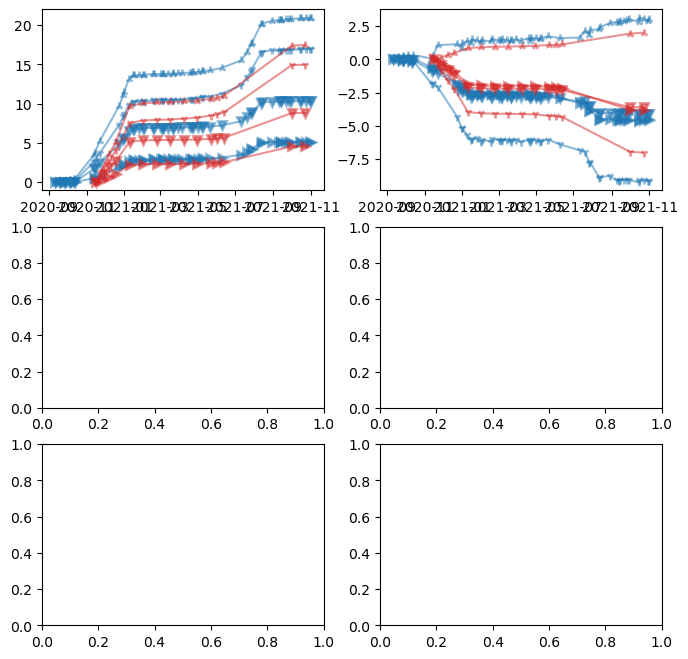

In [27]:
## plot time series of points
from  matplotlib.legend_handler import HandlerTuple
# 0: L1956
# 1: L1948
# 2: L1888 RB2
# 3: L1888 south
# 4: L1998
# 5: L1992
# 6: L1931
# 7: Crater W
# 8: Crater E
# 9: no move
sel1 = [1,2,4,5,]
sel2 = [0,6]
sel3 = [7,8]
#           0   1   2   3   4   5   6   7   8   9 
markers = ['^','>','v','<','1','2','3','x','+','.']
sel_markers1 = [markers[i] for i in sel1]
sel_markers2 = [markers[i] for i in sel2]
sel_markers3 = [markers[i] for i in sel3]

labels = ['L1956','L1948','L1888 RB2', 'L1888 south','L1998','L1992','L1931','Summit dome W','Summit dome E','stable North']
sel_labels1 = [labels[i] for i in sel1]
sel_labels2 = [labels[i] for i in sel2]
sel_labels3 = [labels[i] for i in sel3]
fig, ax = plt.subplots(3,2,figsize=(8,8))

CSK_median_list_sel1 = [CSK_median_list[i] for i in sel1 ]
TSX_median_list_sel1 = [TSX_median_list[i] for i in sel1 ]
CSK_median_list_sel2 = [CSK_median_list[i] for i in sel2 ]
TSX_median_list_sel2 = [TSX_median_list[i] for i in sel2 ]
CSK_median_list_sel3 = [CSK_median_list[i] for i in sel3 ]
TSX_median_list_sel3 = [TSX_median_list[i] for i in sel3 ]


leg_list0 = []
leg_list1 = []
for i, (CSK_med, TSX_med) in enumerate(zip(CSK_median_list_sel1,TSX_median_list_sel1)):
    l1 = ax.ravel()[0].plot(CSK_dates,CSK_med[::2] ,marker=sel_markers1[i],mew=2,color='tab:blue'  ,mfc='tab:blue',alpha=0.5 ,label=sel_labels1[i])
    leg_list0.append(l1)
for i, (CSK_med, TSX_med) in enumerate(zip(CSK_median_list_sel1,TSX_median_list_sel1)):
    l2 = ax.ravel()[0].plot(TSX_dates,TSX_med[::2] ,marker=sel_markers1[i],mew=2,color='tab:red'   ,mfc='tab:red',alpha=0.5,label=' ')
    leg_list0.append(l2)
for i, (CSK_med, TSX_med) in enumerate(zip(CSK_median_list_sel1,TSX_median_list_sel1)):   
    l3 = ax.ravel()[1].plot(CSK_dates,CSK_med[1::2],marker=sel_markers1[i],mew=2,color='tab:blue' ,mfc='tab:blue',alpha=0.5 ,label=sel_labels1[i])
    leg_list1.append(l3)
for i, (CSK_med, TSX_med) in enumerate(zip(CSK_median_list_sel1,TSX_median_list_sel1)):   
    l4 = ax.ravel()[1].plot(TSX_dates,TSX_med[1::2],marker=sel_markers1[i],mew=2,color='tab:red',mfc='tab:red',alpha=0.5 ,label=' ')
    leg_list1.append(l4)
    

handles, labels = ax.get_legend_handles_labels()
ax.ravel()[0].legend(handles=[(handles[0],handles[4]),(handles[1],handles[5]),(handles[2],handles[6]),(handles[3],handles[7])],labels=sel_labels1,ncol=2)

for i, (CSK_med, TSX_med) in enumerate(zip(CSK_median_list_sel2,TSX_median_list_sel2)):
    ax.ravel()[2].plot(CSK_dates,CSK_med[::2] ,marker=sel_markers2[i],mew=2,color='tab:blue'  ,mfc='tab:blue',alpha=0.5 ,label=sel_labels2[i])
    ax.ravel()[2].plot(TSX_dates,TSX_med[::2] ,marker=sel_markers2[i],mew=2,color='tab:red'   ,mfc='tab:red',alpha=0.5)
    ax.ravel()[3].plot(CSK_dates,CSK_med[1::2],marker=sel_markers2[i],mew=2,color='tab:blue' ,mfc='tab:blue',alpha=0.5 ,label=sel_labels2[i])
    ax.ravel()[3].plot(TSX_dates,TSX_med[1::2],marker=sel_markers2[i],mew=2,color='tab:red',mfc='tab:red',alpha=0.5 )

for i, (CSK_med, TSX_med) in enumerate(zip(CSK_median_list_sel3,TSX_median_list_sel3)):
    ax.ravel()[4].plot(CSK_dates,CSK_med[::2] ,marker=sel_markers3[i],mew=2,color='tab:blue'  ,mfc='tab:blue',alpha=0.5 ,label=sel_labels3[i])
    ax.ravel()[4].plot(TSX_dates,TSX_med[::2] ,marker=sel_markers3[i],mew=2,color='tab:red'   ,mfc='tab:red',alpha=0.5)
    ax.ravel()[5].plot(CSK_dates,CSK_med[1::2],marker=sel_markers3[i],mew=2,color='tab:blue' ,mfc='tab:blue',alpha=0.5 ,label=sel_labels3[i])
    ax.ravel()[5].plot(TSX_dates,TSX_med[1::2],marker=sel_markers3[i],mew=2,color='tab:red',mfc='tab:red',alpha=0.5 )

for a in ax.ravel():
    a.set_xlim([datetime.datetime.strptime('2020-09-01','%Y-%m-%d'),datetime.datetime.strptime('2021-12-01','%Y-%m-%d')])
    a.axvline(x=datetime.datetime.strptime('2020-10-13','%Y-%m-%d'),linewidth=1.5,linestyle='--',color='dimgrey')
    a.axvline(x=datetime.datetime.strptime('2021-01-04','%Y-%m-%d'),linewidth=1.5,linestyle='--',color='dimgrey')
    a.axvline(x=datetime.datetime.strptime('2021-07-01','%Y-%m-%d'),linewidth=1.5,linestyle='--',color='dimgrey')
    a.axvline(x=datetime.datetime.strptime('2021-08-14','%Y-%m-%d'),linewidth=1.5,linestyle='--',color='dimgrey')
    # a.legend(ncol=2)
    a.set_xlabel('Date [yyyy-mm]')
    a.set_ylabel('Offset [m]')

    # a.set_yscale('symlog')

# ax.ravel()[2].set_ylim([-4.2,2])
# ax.ravel()[3].set_ylim([-1.5,0.8])
